# Classification Modeling - Update

# Imports

In [2]:
from joblib import parallel_backend
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Import modeling tools, pipelines, models, and metrics

from sklearnex import patch_sklearn
patch_sklearn()

import shap

from sklearn import metrics, set_config
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler

set_config(transform_output='pandas')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Select Features

In [3]:
filepath = '../../data/column_groups.json'
with open(filepath, 'r') as file:
    data = json.load(file)
    
for k, v in data.items():
    print(k, v)

booking_details ['UUID', 'HotelNumber', 'Adults', 'Children', 'Babies', 'Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'DepositType', 'Agent', 'Company', 'CustomerType', 'ADR']
post_stay_details ['UUID', 'AssignedRoomType', 'BookingChanges', 'DaysInWaitingList', 'RequiredCarParkingSpaces', 'ReservationStatus']
reservation_specific ['UUID', 'Meal', 'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled']
temporal_features ['UUID', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights', 'ReservationStatusDate']
new_temporal_features ['ArrivalDateDayName', 'ArrivalDateMonthName', 'ArrivalDate_DaysAfterHoliday', 'ArrivalDate_DaysBeforeHoliday', 'ArrivalDay', 'ArrivalWeek', 'BookingDate_DaysAfterHoliday', 'BookingDate_DaysBeforeHoliday', 'DaysSinceBooking', 'DepartureDate_DaysAfterHoliday', 'DepartureDate_DaysBeforeHoliday', 'Length of Stay']


In [4]:
selected_features = data['booking_details']
selected_features.extend(data['post_stay_details'])
selected_features.extend(data['new_temporal_features'])

selected_features = set(selected_features)
selected_features.remove('UUID')
selected_features.remove('ADR')
selected_features.remove('AssignedRoomType')
selected_features.remove('RequiredCarParkingSpaces')

selected_features = list(selected_features)
selected_features.sort()

In [5]:
selected_features

['Adults',
 'Agent',
 'ArrivalDateDayName',
 'ArrivalDateMonthName',
 'ArrivalDate_DaysAfterHoliday',
 'ArrivalDate_DaysBeforeHoliday',
 'ArrivalDay',
 'ArrivalWeek',
 'Babies',
 'BookingChanges',
 'BookingDate_DaysAfterHoliday',
 'BookingDate_DaysBeforeHoliday',
 'Children',
 'Company',
 'Country',
 'CustomerType',
 'DaysInWaitingList',
 'DaysSinceBooking',
 'DepartureDate_DaysAfterHoliday',
 'DepartureDate_DaysBeforeHoliday',
 'DepositType',
 'DistributionChannel',
 'HotelNumber',
 'Length of Stay',
 'MarketSegment',
 'ReservationStatus',
 'ReservedRoomType']

# Load Data

In [6]:
df_data = pd.read_feather('../../data/3.2_data_with_occupancies.feather', columns=selected_features)
# df_data = pd.read_feather('../../data/3.3_data_exploded.feather', columns=selected_features)
df_data

,Adults,Children,Babies,Country,MarketSegment,DistributionChannel,ReservedRoomType,BookingChanges,DepositType,Agent,...,ArrivalDate_DaysBeforeHoliday,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalWeek,ArrivalDay,ArrivalDateDayName,ArrivalDateMonthName
0,2,0.0,0,PRT,Direct,Direct,C,3,No Deposit,NULL,...,45,21,45,21,22,44,27,3,Wednesday,July
1,2,1.0,0,IRL,Offline TA/TO,TA/TO,A,0,No Deposit,156,...,45,21,38,28,60,32,27,3,Wednesday,July
2,2,0.0,0,IRL,Offline TA/TO,TA/TO,A,0,No Deposit,156,...,45,21,38,28,60,32,27,3,Wednesday,July
3,2,0.0,0,GBR,Offline TA/TO,TA/TO,A,0,No Deposit,115,...,45,21,38,28,56,36,27,3,Wednesday,July
4,3,0.0,0,ESP,Offline TA/TO,TA/TO,A,2,No Deposit,6,...,45,21,40,26,21,71,27,3,Wednesday,July
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,2,0.0,0,FRA,Online TA,TA/TO,A,0,No Deposit,9,...,35,16,32,19,39,12,35,4,Thursday,August
119386,2,0.0,0,GBR,Online TA,TA/TO,A,0,No Deposit,9,...,35,16,33,18,59,44,35,4,Thursday,August
119387,2,0.0,0,GBR,Online TA,TA/TO,D,4,No Deposit,9,...,35,16,33,18,2,49,35,4,Thursday,August
119388,2,0.0,0,GBR,Online TA,TA/TO,A,0,No Deposit,89,...,35,16,28,23,27,13,35,4,Thursday,August


In [7]:
df_data[selected_features]

,Adults,Agent,ArrivalDateDayName,ArrivalDateMonthName,ArrivalDate_DaysAfterHoliday,ArrivalDate_DaysBeforeHoliday,ArrivalDay,ArrivalWeek,Babies,BookingChanges,...,DaysSinceBooking,DepartureDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepositType,DistributionChannel,HotelNumber,Length of Stay,MarketSegment,ReservationStatus,ReservedRoomType
0,2,NULL,Wednesday,July,21,45,3,27,0,3,...,342,21,45,No Deposit,Direct,H1,0,Direct,Check-Out,C
1,2,156,Wednesday,July,21,45,3,27,0,0,...,156,28,38,No Deposit,TA/TO,H1,7,Offline TA/TO,Check-Out,A
2,2,156,Wednesday,July,21,45,3,27,0,0,...,156,28,38,No Deposit,TA/TO,H1,7,Offline TA/TO,Check-Out,A
3,2,115,Wednesday,July,21,45,3,27,0,0,...,152,28,38,No Deposit,TA/TO,H1,7,Offline TA/TO,Check-Out,A
4,3,6,Wednesday,July,21,45,3,27,0,2,...,115,26,40,No Deposit,TA/TO,H1,5,Offline TA/TO,Check-Out,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,2,9,Thursday,August,16,35,4,35,0,0,...,7,19,32,No Deposit,TA/TO,H2,3,Online TA,Check-Out,A
119386,2,9,Thursday,August,16,35,4,35,0,0,...,200,18,33,No Deposit,TA/TO,H2,2,Online TA,Check-Out,A
119387,2,9,Thursday,August,16,35,4,35,0,4,...,334,18,33,No Deposit,TA/TO,H2,2,Online TA,Check-Out,D
119388,2,89,Thursday,August,16,35,4,35,0,0,...,116,23,28,No Deposit,TA/TO,H2,7,Online TA,Check-Out,A


## Transform Target

In [8]:
df_data.loc[:, 'ReservationStatus'] = np.where(df_data['ReservationStatus'] == 'No-Show',
                                               'Canceled',
                                               df_data['ReservationStatus'])
df_data['ReservationStatus'].value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.63
Canceled     0.37
Name: proportion, dtype: float64

# Train/Test Split

In [9]:
target_feature = 'ReservationStatus'

X = df_data.loc[:, selected_features].drop(columns=target_feature)
y = df_data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 903,
                                                    stratify=y)

In [10]:
y_train.value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.63
Canceled     0.37
Name: proportion, dtype: float64

In [11]:
y_test.value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.63
Canceled     0.37
Name: proportion, dtype: float64

# Random Forest Classifer Model Without Tuning

In [12]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##


# Update the categorical pipeline to use OneHotEncoder
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              max_categories=200))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

## --- Combine transformers into a single ColumnTransformer --- ##
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['Adults', 'ArrivalDate_DaysAfterHoliday',
       'ArrivalDate_DaysBeforeHoliday', 'ArrivalDay', 'ArrivalWeek', 'Babies',
       'BookingChanges', 'BookingDate_DaysAfterHoliday',
       'BookingDate_DaysBeforeHoliday', 'Children', 'DaysInWaitingList',
       'DaysSinceBooking', 'De...
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                max_categories=200,
                                                                sparse_output=False))]),
                                 Index(['Agent', 'Company', 'Country', 'CustomerType', 'DepositType',
       'DistributionChannel', 'HotelNumber', 'MarketSegment',
       'ReservedRoomType'],
      dtype='object'))])

In [13]:
X_train_xf = preprocessor.fit_transform(X_train)
X_train_xf

,num__Adults,num__ArrivalDate_DaysAfterHoliday,num__ArrivalDate_DaysBeforeHoliday,num__ArrivalDay,num__ArrivalWeek,num__Babies,num__BookingChanges,num__BookingDate_DaysAfterHoliday,num__BookingDate_DaysBeforeHoliday,num__Children,...,cat__ReservedRoomType_A,cat__ReservedRoomType_B,cat__ReservedRoomType_C,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_G,cat__ReservedRoomType_H,cat__ReservedRoomType_L,cat__ReservedRoomType_P
22630,1.0,4.0,23.0,7.0,40.0,0.0,1.0,5.0,10.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27839,1.0,24.0,79.0,3.0,4.0,0.0,0.0,24.0,79.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57614,1.0,61.0,23.0,3.0,9.0,0.0,0.0,53.0,31.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89102,2.0,25.0,5.0,6.0,47.0,0.0,0.0,12.0,15.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60874,1.0,9.0,20.0,2.0,14.0,0.0,0.0,4.0,25.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67389,2.0,3.0,12.0,7.0,21.0,0.0,0.0,8.0,76.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
32894,2.0,4.0,2.0,6.0,17.0,0.0,0.0,7.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82794,2.0,1.0,26.0,4.0,40.0,0.0,0.0,30.0,36.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102869,2.0,5.0,4.0,5.0,16.0,0.0,0.0,42.0,61.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
for col in X_train_xf.columns:
    print(col)

num__Adults
num__ArrivalDate_DaysAfterHoliday
num__ArrivalDate_DaysBeforeHoliday
num__ArrivalDay
num__ArrivalWeek
num__Babies
num__BookingChanges
num__BookingDate_DaysAfterHoliday
num__BookingDate_DaysBeforeHoliday
num__Children
num__DaysInWaitingList
num__DaysSinceBooking
num__DepartureDate_DaysAfterHoliday
num__DepartureDate_DaysBeforeHoliday
num__Length of Stay
cat__Agent_          1
cat__Agent_          2
cat__Agent_          3
cat__Agent_          4
cat__Agent_          5
cat__Agent_          6
cat__Agent_          7
cat__Agent_          8
cat__Agent_          9
cat__Agent_         10
cat__Agent_         11
cat__Agent_         12
cat__Agent_         13
cat__Agent_         14
cat__Agent_         15
cat__Agent_         16
cat__Agent_         17
cat__Agent_         19
cat__Agent_         20
cat__Agent_         21
cat__Agent_         22
cat__Agent_         23
cat__Agent_         24
cat__Agent_         26
cat__Agent_         27
cat__Agent_         28
cat__Agent_         29
cat__Agent_ 

In [15]:
## --- Build the full pipeline --- ##
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(class_weight='balanced'))])

# Use joblib for parallel processing
with parallel_backend('loky', n_jobs=-1):

    ## --- Fit the model and generate predictions --- ##
    model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

## --- Evaluate performance metrics --- ##
# score_training = model_pipeline.score(X_train, y_train)
# score_testing = model_pipeline.score(X_test, y_test)

## Model Results

### Scoring


Training Score: 1.000
Testing Score: 0.903
Difference: 0.097

              precision    recall  f1-score   support

    Canceled       0.93      0.80      0.86     11056
   Check-Out       0.89      0.96      0.93     18792

    accuracy                           0.90     29848
   macro avg       0.91      0.88      0.89     29848
weighted avg       0.91      0.90      0.90     29848



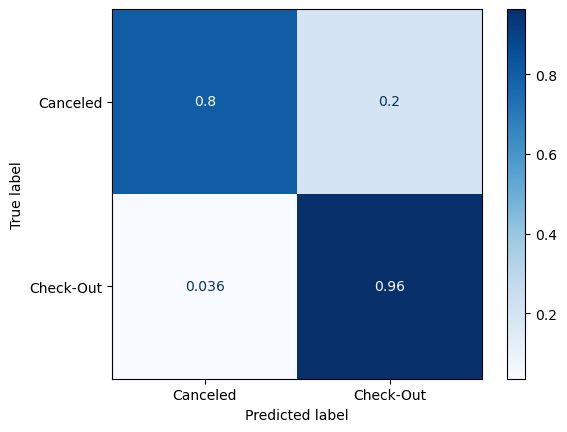

In [16]:
score_training = metrics.f1_score(y_train, model_pipeline.predict(X_train), average='weighted')
score_testing = metrics.f1_score(y_test, y_pred, average='weighted')

print(f'\nTraining Score: {score_training:,.3f}\n'
      f'Testing Score: {score_testing:,.3f}\n'
      f'Difference: {score_training - score_testing:,.3f}\n')

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');

### Permutation Importances

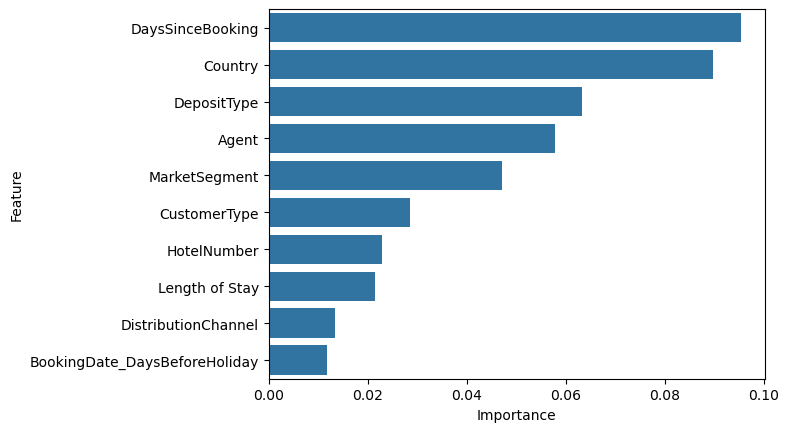

In [17]:
# Calculate permutation importances
result = permutation_importance(model_pipeline,
                                X_test, 
                                y_test,
                                n_jobs=-1,
                                scoring = 'f1_weighted')

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

### Tree Depths

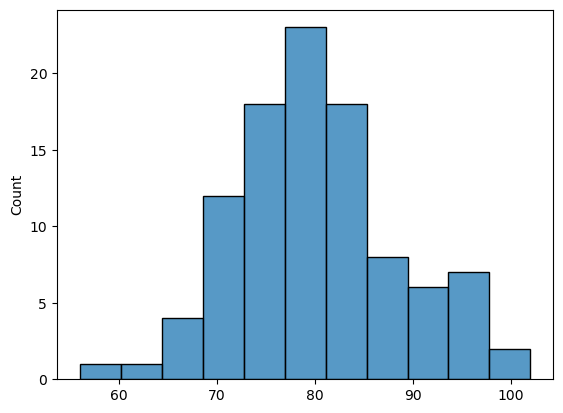

In [18]:
depths = [tree.get_depth() for tree in model_pipeline[-1].estimators_]

sns.histplot(depths);

# Random Forest Classifer Model with Tuning

In [19]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

# Update the categorical pipeline to use OneHotEncoder
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              max_categories=200))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

## --- Combine transformers into a single ColumnTransformer --- ##
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])


# Create the RandomForestClassifier model
classifier = RandomForestClassifier(class_weight='balanced')

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Set up hyperparameter tuning with HalvingGridSearchCV
param_grid = {
    'classifier__max_depth': [25,50,75]}

# Set up Stratified K-Fold
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=False)

# Use joblib for parallel processing
with parallel_backend('loky', n_jobs=-1):
    
    grid_search = GridSearchCV(model_pipeline,
                               param_grid,
                               scoring='f1_weighted',
                               cv=stratified_kfold)

    # Fit the model and generate predictions
    grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Evaluate performance metrics
score_training = best_model.score(X_train, y_train)
score_testing = best_model.score(X_test, y_test)

## RFC Model w/ Tuning Results

### Scoring


Training Score: 1.000
Testing Score: 0.904
Difference: 0.096

              precision    recall  f1-score   support

    Canceled       0.94      0.80      0.86     11056
   Check-Out       0.89      0.97      0.93     18792

    accuracy                           0.91     29848
   macro avg       0.91      0.88      0.90     29848
weighted avg       0.91      0.91      0.90     29848



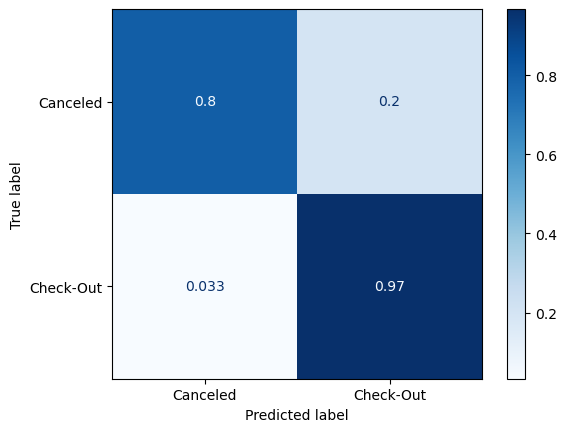

In [20]:
score_training = metrics.f1_score(y_train, best_model.predict(X_train), average='weighted')
score_testing = metrics.f1_score(y_test, y_pred, average='weighted')

print(f'\nTraining Score: {score_training:,.3f}\n'
      f'Testing Score: {score_testing:,.3f}\n'
      f'Difference: {score_training - score_testing:,.3f}\n')

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');

### Permutation Importances

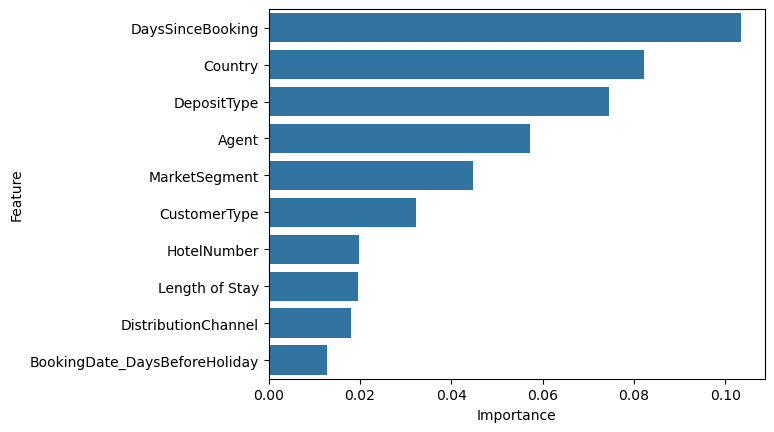

In [21]:
# Calculate permutation importances
result = permutation_importance(best_model,
                                X_test, 
                                y_test,
                                n_jobs=-1,
                                scoring = 'f1_weighted')

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

## SHAP - RFC

In [24]:
X_train_xf = best_model.named_steps.preprocessor.fit_transform(X_train)
X_test_xf = best_model.named_steps.preprocessor.transform(X_test)

In [25]:
X_shap_train = shap.sample(X_train_xf, 500)
y_shap_train = y_train.loc[X_shap_train.index]

X_shap_test = shap.sample(X_test_xf, 500)
y_shap_test = y_test.loc[X_shap_test.index]

: 

In [26]:
explainer = shap.Explainer(best_model.named_steps.classifier, X_shap_train)
# shap_values_train = explainer(X_shap_train)
shap_values_test = explainer(X_shap_test)

In [ ]:
# print(shap_values_train.shape)
print(shap_values_test.shape)

NameError: name 'shap_values_train' is not defined

### Summary Plot

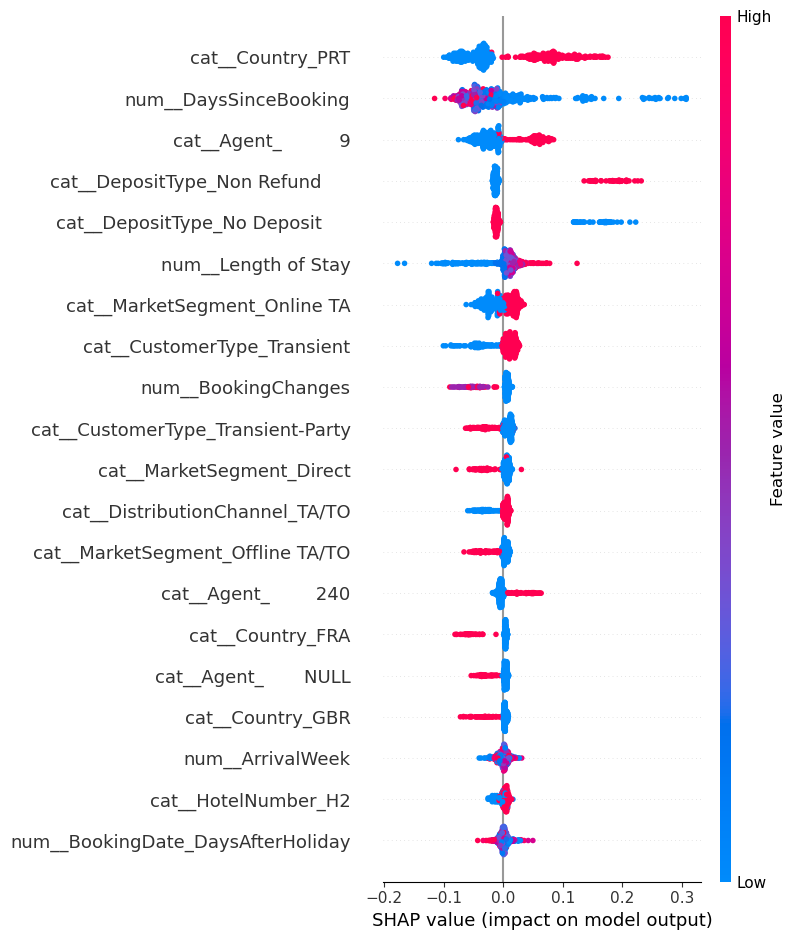

In [93]:
shap.summary_plot(shap_values_test[:, :, 0], X_shap_train)

In [38]:
# df_data.groupby(['Country'])[['ReservationStatus']].value_counts(normalize=True).loc['PRT']

### Force Plot

In [95]:
# For multiple predictions
# shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

# `HistGradientBoostingClassifier` Approach

In [96]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

# Create separate pipelines for categorical and numeric features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              max_categories=200))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('yeojohnson', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

# Create the RandomForestClassifier model
classifier = HistGradientBoostingClassifier(class_weight='balanced',
                                            scoring = 'f1_weighted')

hgbr_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Use joblib for parallel processing
with parallel_backend('loky', n_jobs=-1):
    
    # Fit the model and generate predictions
    hgbr_model_pipeline.fit(X_train, y_train)

hgbr_y_pred = hgbr_model_pipeline.predict(X_test)

# Evaluate performance metrics
hgbr_score_training = hgbr_model_pipeline.score(X_train, y_train)
hgbr_score_testing = hgbr_model_pipeline.score(X_test, y_test)


Training Score: 0.897
Testing Score: 0.887
Difference: 0.010

              precision    recall  f1-score   support

    Canceled       0.85      0.84      0.85     11056
   Check-Out       0.91      0.91      0.91     18792

    accuracy                           0.89     29848
   macro avg       0.88      0.88      0.88     29848
weighted avg       0.89      0.89      0.89     29848



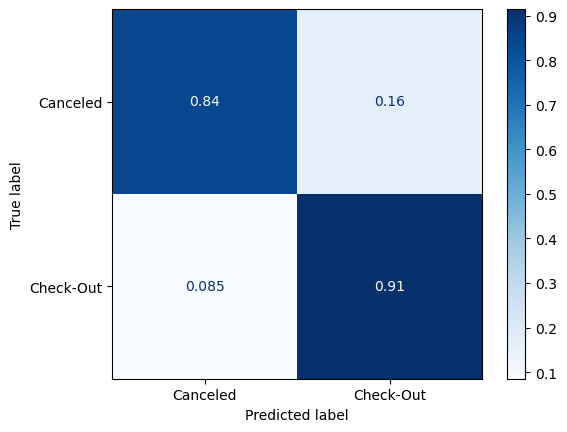

In [97]:
print(f'\nTraining Score: {hgbr_score_training:,.3f}\n'
      f'Testing Score: {hgbr_score_testing:,.3f}\n'
      f'Difference: {hgbr_score_training - hgbr_score_testing:,.3f}\n')

print(classification_report(y_test, hgbr_y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, hgbr_y_pred, cmap='Blues', normalize='true');

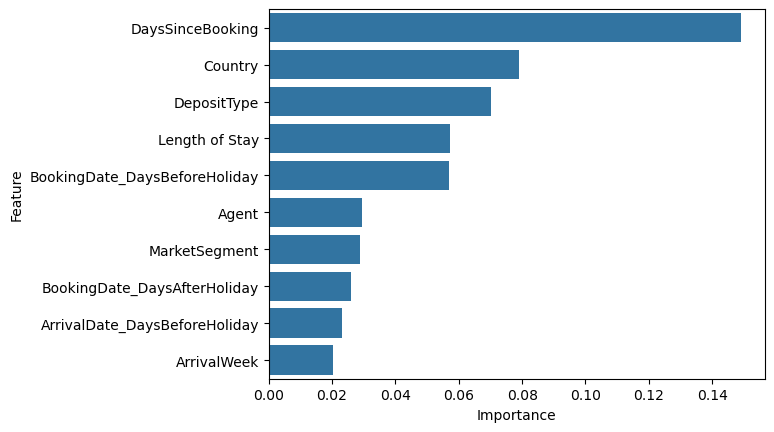

In [98]:
# Calculate permutation importances
result = permutation_importance(hgbr_model_pipeline,X_test, y_test,n_jobs=-1)

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

## SHAP - HGBR

In [99]:
X_train_xf = hgbr_model_pipeline.named_steps.preprocessor.fit_transform(X_train)
X_train_xf

,num__Adults,num__ArrivalDate_DaysAfterHoliday,num__ArrivalDate_DaysBeforeHoliday,num__ArrivalDay,num__ArrivalWeek,num__Babies,num__BookingChanges,num__BookingDate_DaysAfterHoliday,num__BookingDate_DaysBeforeHoliday,num__Children,...,cat__ReservedRoomType_A,cat__ReservedRoomType_B,cat__ReservedRoomType_C,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_G,cat__ReservedRoomType_H,cat__ReservedRoomType_L,cat__ReservedRoomType_P
22630,-1.735585,-1.217414,0.007769,1.495983,0.969073,-0.087023,2.353279,-1.182141,-0.942007,-0.279306,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27839,-1.735585,0.045383,1.491265,-0.476835,-1.800973,-0.087023,-0.424172,-0.017205,1.308317,-0.279306,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57614,-1.735585,1.108766,0.007769,-0.476835,-1.331583,-0.087023,-0.424172,0.894929,0.067967,-0.279306,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89102,0.323414,0.085128,-1.212552,1.021758,1.425386,-0.087023,-0.424172,-0.622392,-0.631227,-0.279306,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60874,-1.735585,-0.752890,-0.129882,-1.013007,-0.909572,-0.087023,-0.424172,-1.293744,-0.160233,-0.279306,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67389,0.323414,-1.346083,-0.586555,1.495983,-0.363910,-0.087023,-0.424172,-0.907257,1.247916,-0.279306,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
32894,0.323414,-1.217414,-1.675955,1.021758,-0.670511,-0.087023,-0.424172,-0.991112,-1.744042,-0.279306,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82794,0.323414,-1.691270,0.133227,0.038018,0.969073,-0.087023,-0.424172,0.213667,0.238058,-0.279306,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102869,0.323414,-1.105154,-1.342670,0.536497,-0.749231,-0.087023,-0.424172,0.599446,0.920913,-0.279306,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
X_shap = shap.sample(X_train_xf, 1000)
X_shap

,num__Adults,num__ArrivalDate_DaysAfterHoliday,num__ArrivalDate_DaysBeforeHoliday,num__ArrivalDay,num__ArrivalWeek,num__Babies,num__BookingChanges,num__BookingDate_DaysAfterHoliday,num__BookingDate_DaysBeforeHoliday,num__Children,...,cat__ReservedRoomType_A,cat__ReservedRoomType_B,cat__ReservedRoomType_C,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_G,cat__ReservedRoomType_H,cat__ReservedRoomType_L,cat__ReservedRoomType_P
36397,0.323414,-0.428666,0.804639,0.038018,0.003929,-0.087023,-0.424172,0.684522,-1.264767,3.580732,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
118080,0.323414,-1.346083,0.830620,0.536497,0.496631,-0.087023,-0.424172,-1.759567,-1.091858,3.580666,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
103848,0.323414,-1.346083,-1.493732,0.536497,-0.670511,-0.087023,-0.424172,-0.017205,1.308317,-0.279306,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44239,-1.735585,-0.125312,1.759332,0.536497,0.701306,-0.087023,-0.424172,0.102288,1.012644,-0.279306,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17955,0.323414,0.304168,0.456351,-1.579268,0.147089,-0.087023,-0.424172,0.739239,1.079143,3.580666,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87091,2.016502,-1.105154,0.092607,1.495983,1.231596,-0.087023,-0.424172,-0.829301,-0.377679,-0.279306,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9342,0.323414,0.403350,0.881427,0.038018,-1.701448,-0.087023,-0.424172,0.351690,0.647403,-0.279306,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52446,0.323414,2.004303,-1.493732,1.021758,1.553215,-0.087023,-0.424172,1.630550,-0.080753,-0.279306,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8936,0.323414,-0.125312,1.201095,0.038018,-1.904640,-0.087023,-0.424172,-1.082143,1.288346,-0.279306,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [107]:
y_shap = y_train.loc[X_shap.index]
y_shap

36397     Check-Out
118080     Canceled
103848    Check-Out
44239     Check-Out
17955      Canceled
            ...    
87091      Canceled
9342      Check-Out
52446     Check-Out
8936      Check-Out
50084      Canceled
Name: ReservationStatus, Length: 1000, dtype: object

In [108]:
hgbr_model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('yeojohnson',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Adults', 'ArrivalDate_DaysAfterHoliday',
       'ArrivalDate_DaysBeforeHoliday', 'ArrivalDay', 'ArrivalWeek', 'Babies',
       'BookingChanges', 'BookingDate_DaysAfterHoliday',
       'Booking...
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 max_categories=200,
                                                                                 sparse_output=False))]),
                                                  Index(['Agent', 'Company', 'Country', 'CustomerType', 'DepositType',
       'DistributionChannel', 'HotelNumber', 'MarketSegment',
       'ReservedRoomType'],
      dtype='object'))])),
                ('classifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                scoring='f1_weighted'))])

In [109]:
# explainer = shap.Explainer(hgbr_model_pipeline.named_steps.classifier, X_shap)
explainer = shap.Explainer(hgbr_model_pipeline.named_steps['classifier'])
shap_values = explainer(X_shap)
shap_values.shape

(1000, 619)

## Summary Plot

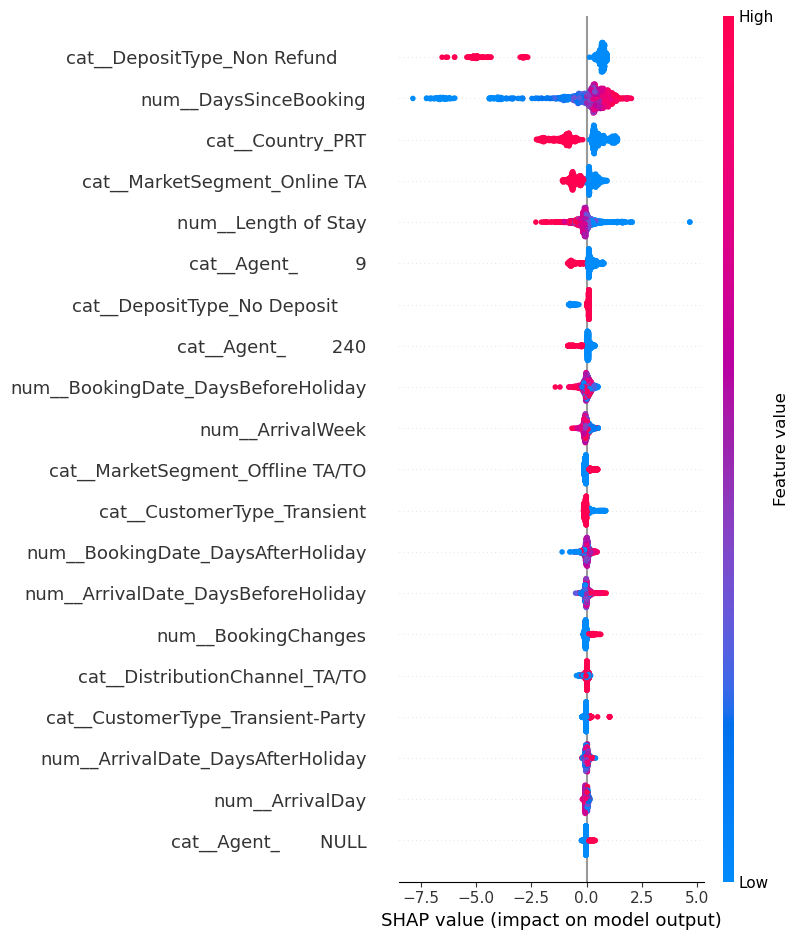

In [110]:
shap.summary_plot(shap_values, X_shap)

## ChatGPT-Suggested Improvements

In [111]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

# Create separate pipelines for categorical and numeric features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              max_categories=200))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('yeojohnson', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

# Create the RandomForestClassifier model
classifier = HistGradientBoostingClassifier(class_weight='balanced',
                                            scoring = 'f1_weighted')

hgbr_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__l2_regularization': [0, 0.1, 0.5],
}

# Set up Stratified K-Fold
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=hgbr_model_pipeline,
                           param_grid=param_grid,
                           cv=stratified_kfold,
                           scoring='f1_weighted')

# Fit the model with grid search
with parallel_backend('loky', n_jobs=-1):
    grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Generate predictions and evaluate performance
hgbr_y_pred = grid_search.predict(X_test)
hgbr_score_training = grid_search.score(X_train, y_train)
hgbr_score_testing = grid_search.score(X_test, y_test)

print(f"Training Score: {hgbr_score_training}")
print(f"Testing Score: {hgbr_score_testing}")

Best Parameters: {'classifier__l2_regularization': 0, 'classifier__learning_rate': 0.2}
Best Score: 0.9005574953417789
Training Score: 0.9185348847657597
Testing Score: 0.9021305579312447
